In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from time import time

In [2]:
train_data = datasets.FashionMNIST(root='data',
                                   train=True,
                                   download=True,
                                   transform=torchvision.transforms.ToTensor(),
                                   target_transform=None
                                   )

test_data = datasets.FashionMNIST(root='data',
                                  train=False,
                                  download=True,
                                  transform=torchvision.transforms.ToTensor(),
                                  target_transform=None
                                  )

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
data_classes = train_data.classes
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

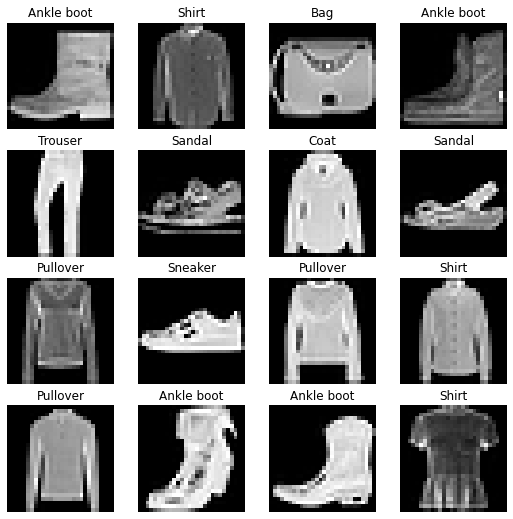

In [ ]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=(1,)).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(data_classes[label])
  plt.axis(False)

In [6]:
train_data_batch = torch.utils.data.DataLoader(train_data, 32, shuffle=True)
test_data_batch = torch.utils.data.DataLoader(test_data, 32, shuffle=True)
train_data_batch, test_data_batch

(<torch.utils.data.dataloader.DataLoader at 0x7f8211f24fd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8211f24dd0>)

In [7]:
len(train_data_batch), len(test_data_batch), len(train_data), len(test_data)

(1875, 313, 60000, 10000)

Sandal


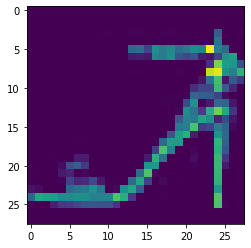

In [ ]:
imgs, labels = next(iter(train_data_batch))

print(data_classes[labels[0]])
plt.imshow(imgs[0].squeeze())

In [ ]:
class VisionFashionMnist(nn.Module):
  def __init__(self, in_feature, hidden_feature, out_feature):
    super().__init__()
    self.FcLayer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=in_feature, out_features=hidden_feature),
        nn.ReLU(),
        nn.Linear(in_features=hidden_feature, out_features=hidden_feature),
        nn.ReLU(),
        nn.Linear(in_features=hidden_feature, out_features=out_feature)
    )

  def forward(self, x: torch.tensor) -> torch.tensor:
    return self.FcLayer(x)

model = VisionFashionMnist(28*28, 32, 10)

loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(),
                      lr=0.01)

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred)
  return (torch.sum(correct)/len(y_true))*100

In [ ]:
a = torch.tensor([1, 2, 3, 4, 5])
b = torch.tensor([1, 1, 3, 4, 6])
accuracy_fn(a, b)

tensor(60.0000)

In [ ]:
# from tqdm.auto import tqdm

torch.manual_seed(42)

start_time = time()
for epoch in range(3):
  print(f'epoch: {epoch} \n-------')
  train_loss = 0
  
  for batch,(X, y) in enumerate(train_data_batch):
    model.train()

    y_logit = model(X)

    loss = loss_fn(y_logit, y)
    train_loss += loss

    opt.zero_grad()
    loss.backward()
    opt.step()

    if batch % 400 == 0:
      print(f'batch {batch}: {(batch * len(X))/len(train_data_batch.dataset):.4f}')

  train_loss /= len(train_data_batch)
  
  test_loss, test_acc = 0, 0
  model.eval()

  with torch.inference_mode():
    for X_test, y_test in test_data_batch:
      y_test_logit = model(X_test)

      test_loss += loss_fn(y_test_logit, y_test)

      test_acc += accuracy_fn(y_test, y_test_logit.argmax(dim=1))

    test_loss /= len(test_data_batch)
    test_acc /= len(test_data_batch)

  print(f'\ntrain loss: {train_loss:.4f} -- test loss: {test_loss:.4f} -- test accuracy: {test_acc:.2f}')
  print(f'Time: {time()- start_time} seconds\n')


end_time = time()
print(f'Total time: {end_time - start_time} seconds')

epoch: 0 
-------
batch 0: 0.0000
batch 400: 0.2133
batch 800: 0.4267
batch 1200: 0.6400
batch 1600: 0.8533

train loss: 0.4348 -- test loss: 0.4515 -- test accuracy: 83.91
Time: 8.06199026107788 seconds

epoch: 1 
-------
batch 0: 0.0000
batch 400: 0.2133
batch 800: 0.4267
batch 1200: 0.6400
batch 1600: 0.8533

train loss: 0.4220 -- test loss: 0.4691 -- test accuracy: 83.48
Time: 16.07524800300598 seconds

epoch: 2 
-------
batch 0: 0.0000
batch 400: 0.2133
batch 800: 0.4267
batch 1200: 0.6400
batch 1600: 0.8533

train loss: 0.4114 -- test loss: 0.4385 -- test accuracy: 84.48
Time: 24.115617275238037 seconds

Total time: 24.115797996520996 seconds


In [ ]:
b, c = next(iter(enumerate(train_data_batch)))